In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.datasets import make_blobs

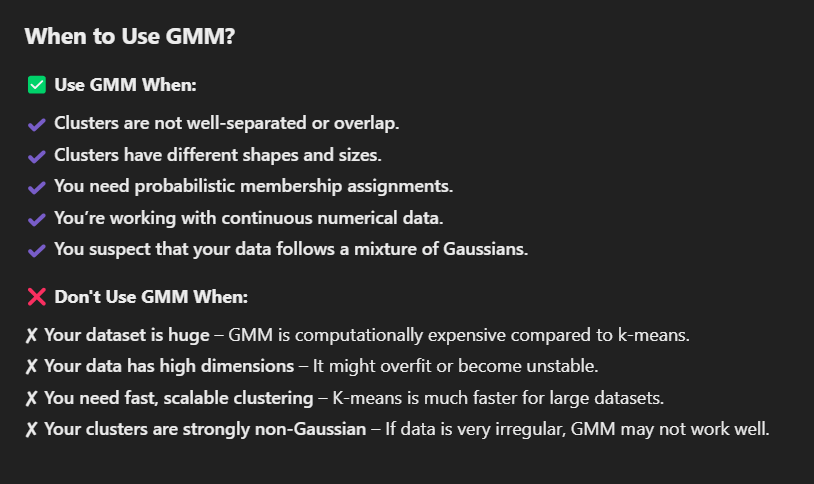

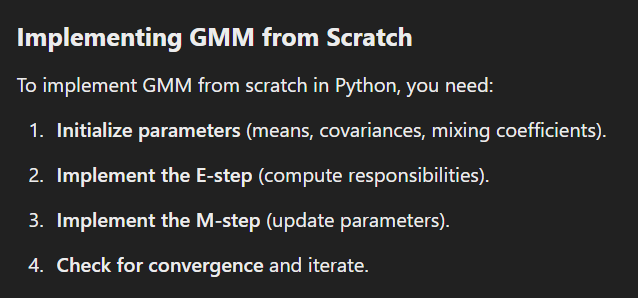

In [2]:
class GMM:
    def __init__(self, n_components, max_iter=100, tol=1e-6):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol

    def initialize_parameters(self, X):
        """Initialize means, covariances, and mixing coefficients."""
        np.random.seed(42)
        n_samples, n_features = X.shape
        
        # Initialize means using random samples
        self.means = X[np.random.choice(n_samples, self.n_components, replace=False)]
        
        # Initialize covariances as identity matrices
        self.covariances = np.array([np.eye(n_features) for _ in range(self.n_components)])
        
        # Initialize mixing coefficients equally
        self.mixing_coeffs = np.ones(self.n_components) / self.n_components

    def e_step(self, X):
        """Compute responsibilities."""
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))
        
        for k in range(self.n_components):
            responsibilities[:, k] = self.mixing_coeffs[k] * multivariate_normal.pdf(X, self.means[k], self.covariances[k])
        
        # Normalize responsibilities
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        return responsibilities

    def m_step(self, X, responsibilities):
        """Update parameters."""
        n_samples, n_features = X.shape
        
        for k in range(self.n_components):
            Nk = responsibilities[:, k].sum()  # Effective number of points assigned to cluster k
            
            # Update means
            self.means[k] = (responsibilities[:, k] @ X) / Nk
            
            # Update covariance
            diff = X - self.means[k]
            self.covariances[k] = (responsibilities[:, k, None, None] * np.einsum('ni,nj->nij', diff, diff)).sum(axis=0) / Nk
            
            # Update mixing coefficients
            self.mixing_coeffs[k] = Nk / n_samples

    def fit(self, X):
        """Train the GMM using the EM algorithm."""
        self.initialize_parameters(X)
        prev_likelihood = -np.inf

        for _ in range(self.max_iter):
            responsibilities = self.e_step(X)
            self.m_step(X, responsibilities)
            
            # Compute log-likelihood
            likelihood = np.sum(np.log(np.sum([
                self.mixing_coeffs[k] * multivariate_normal.pdf(X, self.means[k], self.covariances[k]) 
                for k in range(self.n_components)
            ], axis=0)))

            # Check for convergence
            if np.abs(likelihood - prev_likelihood) < self.tol:
                break
            prev_likelihood = likelihood

    def predict(self, X):
        """Assign data points to the most probable cluster."""
        responsibilities = self.e_step(X)
        return np.argmax(responsibilities, axis=1)


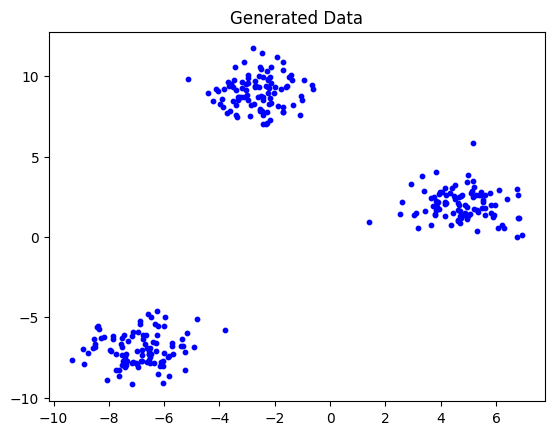

In [4]:
X, y_true = make_blobs(n_samples=300, centers=3, cluster_std=1.0, random_state=42)

# Plot the generated data
plt.scatter(X[:, 0], X[:, 1], s=10, color="blue")
plt.title("Generated Data")
plt.show()

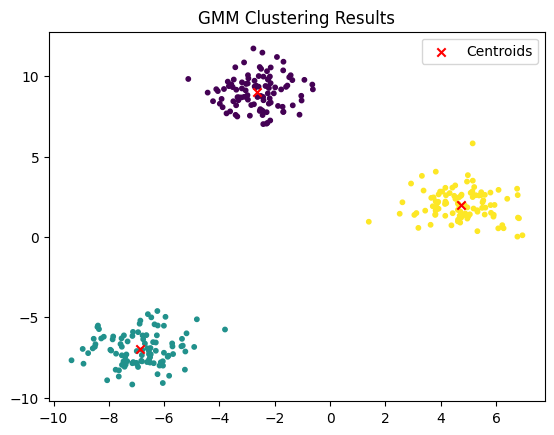

In [5]:
# Instantiate and train our GMM model
gmm = GMM(n_components=3)
gmm.fit(X)

# Predict cluster labels
y_pred = gmm.predict(X)

# Plot clustering results
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis', s=10)
plt.scatter(gmm.means[:, 0], gmm.means[:, 1], c='red', marker='x', label="Centroids")
plt.title("GMM Clustering Results")
plt.legend()
plt.show()

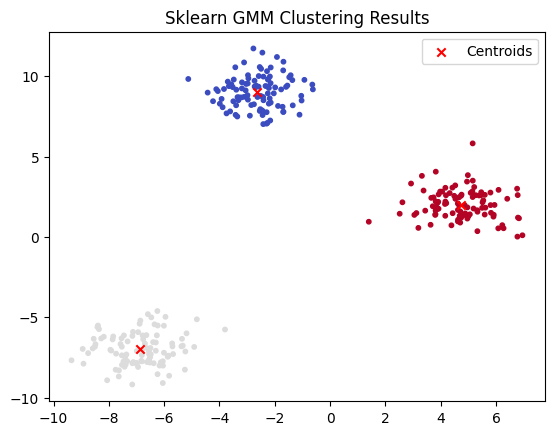

In [7]:
from sklearn.mixture import GaussianMixture

# Train GMM using sklearn
sklearn_gmm = GaussianMixture(n_components=3, random_state=42)
sklearn_gmm.fit(X)

# Predict cluster labels
y_sklearn = sklearn_gmm.predict(X)

# Plot the results
plt.scatter(X[:, 0], X[:, 1], c=y_sklearn, cmap='coolwarm', s=10)
plt.scatter(sklearn_gmm.means_[:, 0], sklearn_gmm.means_[:, 1], c='red', marker='x', label="Centroids")
plt.title("Sklearn GMM Clustering Results")
plt.legend()
plt.show()


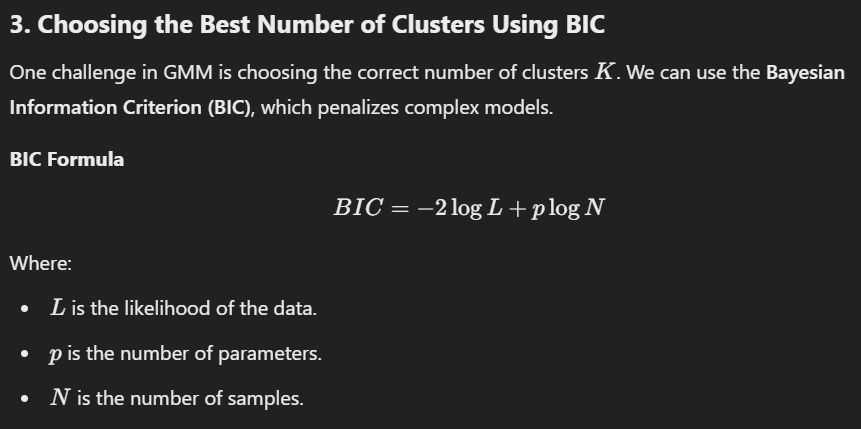

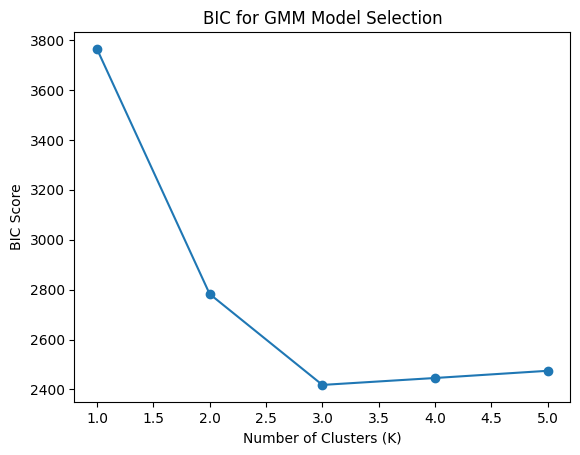

In [8]:
bic_scores = []
n_components_range = range(1, 6)

for k in n_components_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X)
    bic_scores.append(gmm.bic(X))

# Plot BIC scores
plt.plot(n_components_range, bic_scores, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("BIC Score")
plt.title("BIC for GMM Model Selection")
plt.show()
